Installing necessary modules

In [57]:
# Pip installations

# !pip install pandas
# !pip install duckdb
# !pip install matplotlib
# !pip install pyarrow
# !pip install sportypy
# !pip install pybaseball
# !pip install scikit-learn
# !pip install seaborn
# !pip install xgboost
# !pip install shap
# !pip install great_tables
# !pip install ipywidgets --upgrade

Importing necessary packages

In [1]:
# Importing required packages

import numpy as np
import duckdb as db
import pandas as pd
import matplotlib.pyplot as plt
from smt_build_duckdb import readDataSubset
import pyarrow.dataset as pads
import pyarrow.csv as pacsv
import sportypy
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import ttest_ind
import seaborn as sns
import great_tables as gt
import matplotlib.ticker as mtick
import shap

In [8]:
# For code quality, ensuring code satisfies style conventions
# !pip install pycodestyle pycodestyle_magic
# !pip install flake8
# %load_ext pycodestyle_magic

GIF function - courtesy from the Discord

In [2]:
from sportypy.surfaces import MiLBField
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


def plot_animation(player_position_df: pd.DataFrame,
                   ball_position_df: pd.DataFrame,
                   play_id: int = 1,
                   save_gif: bool = False) -> HTML:
    """
    A function that plots field animations for a particular instance of a game.
    Example usage:

    ```
    player_pos = pd.read_parquet('./Combined/player_pos/1884_110_Vis2AR_Home2A.parquet')
    ball_pos = pd.read_parquet('./Combined/ball_pos/1884_110_Vis2AR_Home2A.parquet')

    plot_animation(player_pos, ball_pos, play_id = 30, save_gif = True)
    ```

    Params:
        player_position_df: A Data Frame for the player position coordinates on a field.
        ball_position_df: A Data Frame for the ball position coordiantes on a field.
        play_id: A integer field that denotes the play id you want to visualize. Defaults to 1.
        save_gif: A boolean that when set to true saves the animation to a gif.
                  Defaults to not saving animation (False).

    Returns:
        HTML display of the animation. You can slow or speed up the fps with the + and - buttons.
        You can also press the > arrow to start the animation.
    """

    if not isinstance(play_id, int):
        raise ValueError("Play ID must be an Integer. This function only handles one Play ID.")

    if len(player_position_df['game_str'].unique()) > 1 or len(ball_position_df['game_str'].unique()) > 1:
        raise ValueError(
            "Player Position or Ball Position Data Frame has multiple games. Please filter for one game at a time.")

    player_pos = player_position_df.query(f'play_id == {play_id}')
    ball_pos = ball_position_df.query(f'play_id == {play_id}')

    merged_df = pd.merge(player_pos, ball_pos, on=['timestamp', 'play_id', 'game_str'], how='left')
    merged_df = merged_df[merged_df['player_position'] < 14]  # Elminate umpires and coaches on field

    field = MiLBField()
    field.draw(display_range='full')

    fig = plt.gcf()
    ax = plt.gca()

    p = field.scatter([], [], c='white')
    b = field.scatter([], [], c='red')

    game_id = merged_df['game_str'].unique()[0]
    game_text = ax.text(0, 400, f'Game ID: {game_id}', c='white', ha='center')
    play_text = ax.text(120, 0, f'Play: {play_id}', c='white', ha='center')

    def update(frame):
        frame_data = merged_df[merged_df['timestamp'] <= frame]

        players = frame_data.sort_values('timestamp').drop_duplicates(subset=['player_position'], keep='last')
        balls = frame_data[['ball_position_x', 'ball_position_y', 'ball_position_z']].dropna().iloc[-1:]

        players_colors = ['yellow' if 10 <= pos <= 13 else 'white' for pos in players['player_position']]

        p.set_offsets(np.c_[players['field_x'], players['field_y']])
        p.set_color(players_colors)

        ball_size = (balls['ball_position_z'].values * 8)
        b.set_offsets(np.c_[balls['ball_position_x'], balls['ball_position_y']])

        if ball_size.size > 0:
            if ball_size < 1:
                ball_size = np.array([10])


        return p, b

    ani = FuncAnimation(fig, update, frames=np.linspace(merged_df['timestamp'].min(),
                                                        merged_df['timestamp'].max(), num=50), blit=True)

    if save_gif:
        ani.save('animation.gif', writer='imagemagick', fps=10)

    return HTML(ani.to_jshtml())

Reading necessary files and creating pandas dataframes

In [3]:
# %%pycodestyle
# Importing necessary files as pd dfs

game_info_subset = readDataSubset('game_info')
game_info = game_info_subset.to_table().to_pandas()

game_events_subset = readDataSubset('game_events')
game_events = game_events_subset.to_table().to_pandas()

player_position_subset = readDataSubset('player_pos')
player_position = player_position_subset.to_table().to_pandas()

ball_position_subset = readDataSubset('ball_pos')
ball_position = ball_position_subset.to_table().to_pandas()

### Data cleaning

In [4]:
# %%pycodestyle
# Remaking at_bat column in game_info due to incorrect/missing values
# This script is thanks to Fred Danese on the Discord
# Essentially, if the batter changes (ID or to an NA),
# the increment the at bat count by 1
# Or if the game changes, increment the at bat

at_bat = list()
for row in range(len(game_info)):

    if row == 0:
        at_bat = at_bat + [1]

    elif game_info.loc[row, 'game_str'] != game_info.loc[row-1, 'game_str']:
        at_bat = at_bat + [1]

    elif game_info.loc[row, 'batter'] == game_info.loc[row-1, 'batter']:
        at_bat = at_bat + [at_bat[row-1]]

    else:
        at_bat = at_bat + [at_bat[row-1] + 1]

game_info['at_bat'] = at_bat

In [5]:
# %%pycodestyle
# Adding an 'inning' column in game_info
# Script also courtesy of Fred Danese (thanks Fred!)

inning = list()
for row in range(len(game_info)):
    # The first inning always 1
    if game_info.loc[row, 'play_per_game'] == 1:
        inning = inning + [1]

    # If game_str switches, start back at 1
    elif game_info.loc[row, 'game_str'] != game_info.loc[row-1, 'game_str']:
        inning = inning + [1]

    # If top_bottom is same, inning hasnt swtiched
    elif game_info.loc[row, 'top_bottom_inning'] == game_info.loc[
        row-1,
        'top_bottom_inning'
    ]:
        inning = inning + [inning[row-1]]

    # If in top of inning (and top_bottom_inning doesnt match previous row
    # (implied from prev elif))
    # take previous inning number and increment by 1
    elif game_info.loc[row, 'top_bottom_inning'] == 'top':
        inning = inning + [inning[row-1] + 1]

    # Otherwise, going from top of inning to bottom of inning, so keep inning
    # number the same
    else:
        inning = inning + [inning[row-1]]

game_info['inning'] = inning

In [6]:
# Filling in missing at_bat in game_events df

# Merge game_events with game_info since info has the
# correct at_bat column.
# This will match identifying variables game_str and
# play_per_game to the correct at bats
# Using these two variables since they identify specific
# plays and were in both dfs.

game_events_merged = game_events.merge(game_info,
                                       on=['game_str', 'play_per_game'])

game_events_merged = game_events_merged[[
    'game_str', 'play_id',
    'play_per_game', 'at_bat_y',
    'timestamp', 'player_position',
    'event_code', 'home_team_x',
    'away_team_x', 'year_x',
    'day_y'
]]

game_events_merged = game_events_merged.rename(columns={
    'at_bat_y': 'at_bat',
    'home_team_x' : 'home_team',
    'away_team_x': 'away_team',
    'year_x': 'year',
    'day_y' : 'day'
})

### Data Wrangling - Creating Desired DF

Find a way to capture pickoff attempts to first base

In [7]:
# Finding pickoff attempts

# Filter plays where pitcher performs a pickoff and
# the first baseman catches it
# Yes, this ignores errant throws, but it captures
# true pickoff attempts to first base

# Basically, filtering plays where:
# Pitcher throws over, first baseman catches

pickoff_attempts = game_events_merged[
    (game_events_merged['event_code'] == 2) &
    (game_events_merged['player_position'] == 3) &
    (game_events_merged['event_code'].shift(1) == 6) &
    (game_events_merged['player_position'].shift(1) == 1)
]

Note: Errant throws would also (most of the time) lead to the runner advancing to second, defeating the crux of this project, so it's okay to try and ignore them

Now, find steal attempts, first to second base

In [8]:
# Finding pitches without a ball being put into play
# (for pinpointing objective steal attempts)

# Only events where pitcher pitches and catcher catches,
# no ball put in play

not_in_play = game_events_merged[
    (game_events_merged['event_code'] == 2) &
    (game_events_merged['player_position'] == 2) &
    (game_events_merged['event_code'].shift(1) == 1) &
    (game_events_merged['player_position'].shift(1) == 1)
]

not_in_play = not_in_play[[
    'game_str',
    'play_id',
    'at_bat'
]]

In [9]:
# Finding potential steal attempts

# Plays where it is just a pitch but runner breaks, ie steals.
steals = player_position.merge(not_in_play, on=[
    'game_str',
    'play_id'
])

steals = steals[(steals['player_position'] == 11)]

# Find when pitcher pitches, catcher catches,
# yet the runner is well off 1b -> indicates a steal attempt

# If the runner is wayyy off the bag and close to second,
# I can assume some sort of advancement is taking place
steals = steals[steals['field_x'] < 30]
steals = steals.drop_duplicates(subset=['game_str', 'play_id'])

In [10]:
# Further developing steals df, dropping duplicates, cleaning, etc.

steals_events = game_events_merged.merge(steals, on=[
    'game_str',
    'play_id',
    'at_bat'
])

steal_events_unique = steals_events.drop_duplicates(subset=[
    'game_str',
    'play_id',
    'at_bat'
])

steals_df = steal_events_unique[[
    'game_str',
    'play_id',
    'play_per_game'
]]

Filtering out passed balls

In [11]:
# Merge steals with ball position to see if the ball passed the
# catcher or did something weird
passed_balls = ball_position.merge(steals_df, on=['game_str', 'play_id'])

# If ball got passed catcher by 10 feet, exclude. I also
# manually checked using GIFs if
# the plays I removed were wild pitches/passed balls, and they were.
pb_games = passed_balls[passed_balls['ball_position_y'] < -10].drop_duplicates(
    subset=['game_str', 'play_id'])['game_str'].values

pb_id = passed_balls[passed_balls['ball_position_y'] < -10].drop_duplicates(
    subset=['game_str', 'play_id'])['play_id'].values

# Rows to remove by index (passed balls, don't want these)
pb_index = steals_df[(steals_df['game_str'].isin(pb_games)) &
                     (steals_df['play_id'].isin(pb_id))].index

# Remove passed balls from steals df
steals_df = steals_df.drop(pb_index)

Only including stolen bases with a runner on first. Since game_info has plenty of incorrect rows, we need to use player_pos

In [12]:
# Identifying attempts where only a runner is on first

# First find player_position rows where runners are on base
# 11 is first, 12 second, 13 third
on_base = player_position[player_position['player_position'].isin(
    [11, 12, 13]
)]

# Create a dummy column to quantify runners existing on their respective base
on_base = on_base.assign(existing=1)

# Then create pivot table
# https://pandas.pydata.org/docs/user_guide/reshaping.html
# to populate first, second, third base for each play
pt = pd.pivot_table(on_base,
                    index=['game_str', 'play_id'],  # Index by game str and play id, good id variables
                    columns='player_position',  # Pivot columns are first, second, and third base.
                    values='existing',  # Fill in the columns with 1 if populated
                    fill_value=0)  # Fill in the unpopulates bases with 0

# Next, filter out to only include plays where runner is ONLY on first
# To avoid looping, need a vectorized function to use in apply() row by row

def is_only_on_first(row):
    '''
    Filters in a pivot df to only include plays where runner is
    only on first

    params:
        row: a singular row of a df to be applied to
    returns:
        A vector indicating whether play is valid or not
    '''

    # First is populated, but second and third are empty
    if row[11] == 1 and row[12] == 0 and row[13] == 0:
        return 1

    # If any other circumstance, set to 0 to remove
    else:
        return 0


# Apply function across rows, creating a new column indicating
# whether to keep/remove
pt['only_first'] = pt.apply(is_only_on_first, axis=1)

# Only keep rows where runner is only on first
indexes_only_first = pt[pt['only_first'] == 0].index
pt = pt.drop(indexes_only_first)

# Now, merge plays with only runner on first with our steals df
steals_df_final = steals_df.merge(pt, on=['game_str', 'play_id'])

# Remove the extraneous columns
steals_df_final = steals_df_final.drop([11, 12, 13, 'only_first'], axis=1)

Find at bats in which pickoff moves occur - Only at bats with at least 1 pickoff move, and then only plays with no ball in play

In [13]:
# Only at bats with at least 1 pickoff move, and then only
# plays with no ball in play

# Filter out NA values
ab_pa = pickoff_attempts[~(pickoff_attempts['at_bat'] == '\\N')]
ab_pa = ab_pa.drop_duplicates(subset=['game_str', 'at_bat'])

# Pickoff at bats df
ab_pa = ab_pa[['game_str', 'play_id', 'at_bat', 'play_per_game']]

# Now, obtain pitches that occur after each pickoff and during the at bat
pickoff_events = game_events_merged.merge(ab_pa, on=['game_str', 'at_bat'])
pickoff_pitches = pickoff_events[['game_str', 'play_id_x',
                                  'at_bat', 'timestamp',
                                  'play_per_game_x', 'player_position',
                                  'event_code']]

# Rename columns, clean up df
pickoff_pitches = pickoff_pitches.rename(columns={
    'play_id_x': 'play_id'
})

# Now merge to only include pitches where ball was NOT put into play
pickoff_pitches = not_in_play.merge(pickoff_pitches, on=[
    'game_str', 'play_id'
])

# Clean up df
pickoff_pitches = pickoff_pitches.drop(columns=['at_bat_y'])
pickoff_pitches = pickoff_pitches.rename(columns={
    'at_bat_x': 'at_bat',
    'play_per_game_x': 'play_per_game'
})
pickoff_pitches = pickoff_pitches.drop_duplicates(subset=[
    'game_str', 'play_id'
])

# Like with steals, only keep pitches where only runner is on first
pickoff_pitches = pickoff_pitches.merge(pt, on=[
    'game_str', 'play_id'
])
pickoff_pitches = pickoff_pitches.drop([
    'player_position', 'event_code',
    11, 12, 13, 'only_first'
],
    axis=1)

# Same with pickoff_attempts
pickoff_attempts = pickoff_attempts.merge(pt, on=['game_str', 'play_id'])

Now, only keep pitches after the pickoff has occurred, and quantify how many pickoffs have occured before a certain pitch

In [14]:
def is_before_or_after(row):
    '''
    Assesses whether current pitch happened before or after a
    pickoff attempt...
    or sometime between!

    params:
    row: a singular row of a df to be applied to (in my case, a pitch)
    returns:
    Number of pickoffs that have occurred before this current pitch (if any)
    '''

    # Use play_per_game to sequence, and use at_bat and game_str to
    # index
    game_str = row['game_str']
    at_bat = row['at_bat']
    play = row['play_per_game']

    # Find which pickoffs occurred before this play
    pickoffs_this_ab = pickoff_attempts[
        (pickoff_attempts['game_str'] == game_str) &
        (pickoff_attempts['at_bat'] == at_bat) &
        (pickoff_attempts['play_per_game'] < play)
    ]

    # Now assess whether current pitch happened before or after a
    # pickoff
    if pickoffs_this_ab.empty:
        return 0 # To remove

    # If 1 pickoff move occurred before
    elif len(pickoffs_this_ab) == 1:
        return 1

    # If more than 1 pickoff occurred before this pitch, simply
    # mark as 2 (insinuating just 2 or more as one category)
    else:
        return 2

# Apply function onto pickoff_pitches df
pickoff_pitches['pickoffs'] = pickoff_pitches.apply(is_before_or_after,
                                                    axis=1)
# Remove pitches that occurred before pickoff
before_any_pickoffs = pickoff_pitches[pickoff_pitches['pickoffs'] == 0].index
pickoff_pitches = pickoff_pitches.drop(before_any_pickoffs)

Now find the pitches where a steal occurs (main classifier problem)

In [15]:
# 11 is first, 12 second, 13 third
in_steals = pickoff_pitches.merge(steals_df_final, on=[
    'game_str',
    'play_per_game'
])

def in_steals_func(row):
    '''
    Assesses whether stolen base attempt occurs during this pitch
    param: row: a df to be applied to (in my case, a pitch)
    returns:
    1 if a steal, 0 otherwise
    '''

    game_str = row['game_str']
    play = row['play_per_game']

    if in_steals[
        (in_steals['game_str'] == game_str) &
        (in_steals['play_per_game'] == play)
    ].empty:
        return 0
    else:
        return 1

# Apply it to pickoff pitches, creating a new col
# indicating if stolen base attempt will occur at current pitch
pickoff_pitches['steal'] = pickoff_pitches.apply(in_steals_func, axis=1)

In [16]:
len(pickoff_pitches[pickoff_pitches['steal'] == 1]) # 57 steals

57

57 steals occur after a pitcher has thrown over

Helper function; calculates the coordinates of first base

In [17]:
def first_base_coords(edge=False):
    '''
    Calculates center of first base coordinates
    params:
        edge: bool variable for the user to decide if they want
        the left corner of first base

    returns:
        coordinates of first base
    '''

    # Since we have distance from back of home to back corner of first,
    # use some trig
    x, y = np.sin(np.deg2rad(45))*90, np.cos(np.deg2rad(45))*90

    # Getting the inner corner for leadoff purposes
    diagonal = np.sqrt(15**2 + 15**2)
    if edge:
        # Only x changes
        return np.array([x - (diagonal/12), y])
    else:
        return np.array([x, y])


Find lead distances for the runner on first base before the pitch is thrown. The lead is ideally measured 1-1.2 seconds before the pitcher releases the ball, as this is roughly the timeframe where a pitcher makes their move to homeplate, and a runner is simply holding their lead and not breaking for second yet. Although not perfect, this approach is a good estimate for a runner's lead before a pitch is thrown.

Oftentimes, a play's timestamp data will begin when the pitch is released, so we do not know a runner's position before then. At this time, the runner is much closer to second base than 1 second before due to stolen base attempts or secondary leads. So, I need to predict and adjust these values to what they would have been ~1.2 seconds earlier

In [18]:
# Initialize first base to measure the inside egde of base
first_base = first_base_coords(True)

positional = pickoff_pitches.merge(player_position,
                                   on=['game_str', 'play_id']).rename(
    columns={'timestamp_y': 'timestamp'})


def calc_lead_distance(row):
    '''
    Calculates the Euclidean distance between the runner and the
    inner edge of first base,
    approximately before the pitcher initiates their delivery (1.2
    seconds before the pitch is released.
    This may be generous, but I wanted to be safe and ensure the
    pitcher (probably) has not started delivery.)

    param:
        row: a df to be applied to (in my case, a pitch)
    returns:
        The Euclidean distance between the runner and the inner
        edge of first base for pitch instance
    '''

    # Identity variables
    game = row['game_str']
    play = row['play_per_game']

    # The timestamp at point of pitch release (important!)
    timestamp = row['timestamp']

    # Find play in the player position df defined above, filter for first
    # baserunner as well
    temp = positional[
        (positional['game_str'] == game) &
        (positional['play_per_game'] == play) &
        (positional['player_position'] == 11)
    ]

    if temp.empty:
        return 0
    # Player x, y position at ~1.2 seconds before pitch release
    leads = temp[
        (temp['timestamp'] >= timestamp - 1200) &
        (temp['timestamp'] <= timestamp - 1150)
    ]

    # If the pre-release data exists (this is what we want)
    if leads.size > 0:
        x, y = leads['field_x'].values[0], leads['field_y'].values[0]

        # Return the Euclidean distance between first and current player
        # location
        return np.linalg.norm(first_base - np.array([x, y]))

    # If data begins at release (not ideal, but we can try to
    # adjust it)
    else:
        x, y = temp['field_x'].values[0], temp['field_y'].values[0]

        return np.linalg.norm(first_base - np.array([x, y]))


def needs_adjustment(row):
    '''
    For filtering which pitches had its timestamps start at time of
    pitch release. This error is common in the dataset but is
    consistently always the same issue (timestamp literally just starts at
    time of pitch release, and nothing before to track runner aggression).

    params:
    row: a df to be applied to (in my case, a pitch)
    returns:
    1 if needs adjustment, 0 otherwise
    '''

    game = row['game_str']
    play = row['play_per_game']

    # The timestamp at point of pitch release (important!)
    timestamp = row['timestamp']

    # Find play in the player position df defined above, filter for
    # first baserunner as well
    temp = positional[
        (positional['game_str'] == game) &
        (positional['play_per_game'] == play) &
        (positional['player_position'] == 11)
    ]

    # If needs to be removed
    if temp.empty:
        return 2
    # Player x, y position at ~1.2 seconds before pitch release
    leads = temp[
        (temp['timestamp'] >= timestamp - 1200) &
        (temp['timestamp'] <= timestamp - 1150)
    ]

    # If the pre-release data exists (this is what we want)
    if leads.size > 0:
        return 0

    # If data begins at release (not ideal, but we can try to adjust it)
    else:
        return 1


# This takes ~1 min
pickoff_pitches['lead'] = pickoff_pitches.apply(calc_lead_distance, axis=1)
pickoff_pitches['adjust'] = pickoff_pitches.apply(needs_adjustment, axis=1)

There are no rows to remove (missing data entirely), which is good

## Lead Adjustments Due to Imperfect Data

Just using the mean difference to adjust. All measurements are ~1.2 seconds off of what I want them to be (they are at the literal time of pitch release, which is good), so I feel like this is fair.

In [19]:
# Quick difference between the lead distances with the bad data
# and the good data
at_release = np.mean(
    pickoff_pitches[pickoff_pitches['adjust'] == 1]['lead']
)
before_release = np.mean(
    pickoff_pitches[pickoff_pitches['adjust'] == 0]['lead']
)

delta_mean_lead = at_release - before_release


def adjust_leads(row):
    '''
    Mean adjusting leads that were measured at time of pitch release.
    Adjustment will hopefully give me a good measure of where the
    runner could have been 1.2 seconds beforehand.
    param:
    row: a df to be applied to (in my case, a pitch)
    return:
    newly adjusted lead distance (if needed)
    '''

    # Subtract by mean difference if needed
    if row['adjust'] == 1:
        return row['lead'] - delta_mean_lead
    else:
        return row['lead']


pickoff_pitches['lead_adj'] = pickoff_pitches.apply(adjust_leads, axis=1)

In [20]:
print(f"The difference between leads before pitcher delivery and leads at time of pitch release is {delta_mean_lead}") # 3.3900681843303673

The difference between leads before pitcher delivery and leads at time of pitch release is 3.3900681843303673


Adjusting by over 3 feet, which is expected. This is around how much a runner advances during pitcher delivery (sometimes way more, sometimes less (or negative), but it's an understandable average).

More features: Finding handedness

In [21]:
release = pickoff_pitches.merge(ball_position,
                                on=['game_str', 'play_id']
                                ).rename(
    columns={'timestamp_y': 'timestamp'})

def is_right_or_left(row):
    '''
    Assesses whether current pitcher is left or right at time
    of pitch release (idk maybe someone is a switch pitcher)
    params:
    row: a df to be applied to (in my case, a pitch)
    returns:
    1 if current pitcher is lefty, 0 if righty, 2 if missing data
    '''

    game = row['game_str']
    play = row['play_id']
    temp = release[(release['game_str'] == game) &
                   (release['play_id'] == play)
    ]

    if temp.empty:
        return 2

    # If release on the side towards first base (ie lefty)
    if temp['ball_position_x'].values[0] > 0:
        return 1

    # If release on the side towards third base (ie righty)
    if temp['ball_position_x'].values[0] < 0:
        return 0

pickoff_pitches['handedness'] = pickoff_pitches.apply(is_right_or_left, axis=1)

# Removing the few missing values (none were steal attempts - I checked)
missing_handedness = pickoff_pitches[pickoff_pitches['handedness'] == 2].index
pickoff_pitches = pickoff_pitches.drop(missing_handedness)

Feature: Game State (inning)

In [22]:
which_inning = pickoff_pitches.merge(game_info,
                                     on=['game_str', 'play_per_game'])

def find_which_inning(row):
    '''
    Assigns inning to a pitch
    param:
    row: a df to be applied to (in my case, a pitch)
    returns:
    the inning
    '''
    game = row['game_str']
    play = row['play_per_game']
    inning = which_inning[(which_inning['game_str'] == game) & (which_inning['play_per_game'] == play)]['inning'].values[0]

    return inning

# Add inning column to df
pickoff_pitches['inning'] = pickoff_pitches.apply(find_which_inning, axis=1)

Feature: Time between the current pitch and the last pickoff attempt

In [23]:
# Similar logic to finding how many pickoffs occurred before a single pitch

def calc_time_between(row):
    '''
    Calculates the time between this pitch and the last pickoff attempt

    params:
    row: a singular row of a df to be applied to (in my case, a pitch)
    returns:
    Number of pickoffs that have occurred before this current pitch (if any)
    '''

    # Use play_per_game to sequence, and use at_bat and game_str to index
    game_str = row['game_str']
    at_bat = row['at_bat']
    play = row['play_per_game']

    # Find which pickoffs occurred before this play
    pickoffs_this_ab = pickoff_attempts[(pickoff_attempts['game_str'] == game_str) &
                                        (pickoff_attempts['at_bat'] == at_bat) & (pickoff_attempts['play_per_game'] < play)
    ]

    # Get most recent play's timestamp
    pickoff_timestamp = pickoffs_this_ab['timestamp'].values[-1]
    curr_timestamp = row['timestamp']
    delta = curr_timestamp - pickoff_timestamp

    # Return the time between in seconds (from milliseconds)
    return delta / 1000

pickoff_pitches['time_between'] = pickoff_pitches.apply(calc_time_between, axis=1)

Finding specific pitchers and baserunner IDs for speed calculations

In [24]:
# game_info is missing tons of player ID's and has incorrect values even

baserunners = pickoff_pitches.merge(game_info, on=['game_str', 'play_per_game'])

def whos_on_first(row):
    '''
    Finds runner ID for runner on first base
    params:
    row: a df to be applied to (in my case, a pitch)
    returns:
    baserunner ID string
    '''

    game = row['game_str']
    play = row['play_per_game']
    temp = baserunners[(baserunners['game_str'] == game) & (baserunners['play_per_game'] == play)]
    if temp.empty:
        return np.nan
    else:
        return temp['first_baserunner'].values[0]

pickoff_pitches['runner'] = pickoff_pitches.apply(whos_on_first, axis=1)

In [25]:
# player ID missing values are string NA's. Taking note of that
len(pickoff_pitches[pickoff_pitches['runner'] == 'NA']) # 74 rows of missing runners

74

Finding average sprint speed for the baserunners. Attempting to look at plays where the runner is sprinting. Measuring sprint speed in short sub 1 second intervals. Trying to emulate MLB's definition of sprint speed, where they measure qualified runs as runs of 2 or more bases and runs as home-to-first on weakly hit balls.
This might be tricky, but trying my best.

In [26]:
# IDs of all baserunners
baserunners_list = list(set(pickoff_pitches[pickoff_pitches['runner'] != 'NA']['runner']))

# Create new df of baserunners and then calculate their respective avg sprint speeds
baserunners_df = pd.DataFrame()
baserunners_df['runner'] = baserunners_list

# Find plays where specific players in the runner ID list hits ball into play
# Filtering instances where batter hit ball and ball bounces after, indicating a ground ball.
# Again, just trying to emulate instances where the runner runs their fastest

runners_hit = game_events_merged[(game_events_merged['event_code'] == 16) & (game_events_merged['event_code'].shift(1) == 4)][['game_str', 'play_per_game', 'play_id']]
runners_hit = game_info.merge(runners_hit, on=['game_str', 'play_per_game'])
runners_hit = runners_hit[runners_hit['batter'].isin(baserunners_list)]

# Now merge this df with player positional data to for calculating sprint speeds
batting = player_position[player_position['player_position'].isin([10])]
runners_pos = runners_hit.merge(batting, on=['game_str', 'play_id'])

def calc_sprint_speed(row):
    '''
    Calculates average sprint speed for a given player by taking their fastest
    1-second spurts during plays where they are (hopefully) sprinting
    params:
    row: a player
    returns:
    baserunner's average sprint speed
    '''
    player_id = row['runner']

    plays = runners_pos[runners_pos['batter'] == player_id]

    plays_id = plays[['game_str', 'play_per_game']].drop_duplicates()

    speeds = list()
    for i in range(len(plays_id)):
        game, play = plays_id['game_str'].values[i], plays_id['play_per_game'].values[i]
        runner_data = plays[(plays['game_str'] == game) & (plays['play_per_game'] == play)]

        # Mini interval initial location (vectorized)
        curr = runner_data[['field_x', 'field_y']].values

        # Next location (vectorized, shifted 1)
        next = runner_data[['field_x', 'field_y']].shift(-1).values

        timestamps = (runner_data['timestamp'].shift(-1) - runner_data['timestamp']).values
        timestamps_mask = ~np.isnan(timestamps)
        timestamps = timestamps[timestamps_mask]

        # Find burst distances
        euc_distances = np.linalg.norm(next - curr, axis=1)
        mask_euc = ~np.isnan(euc_distances)
        euc_distances = euc_distances[mask_euc]

        # Calculate burst speeds over ~50ms intervals
        speed = (euc_distances / timestamps) * 1000
        mask_speed = ~np.isnan(speed)
        speed = speed[mask_speed]

        # Capturing player's fastest window (half second window)
        max_speed = 0.00
        for j in range(len(speed) - 10):
            combined = np.mean(speed[j:j+10])
            if combined > max_speed:
                max_speed = combined

        # If a reasonable speed
        if 23 < max_speed < 32:
            speeds.append(max_speed)

    if len(speeds) == 0:
        return np.nan
    else:
        return np.mean(speeds)

baserunners_df['speed'] = baserunners_df.apply(calc_sprint_speed, axis=1)

In [27]:
print(f"The average sprint speed is {np.mean(baserunners_df['speed']):.2f} ft/sec") # 26.95 ft/sec

The average sprint speed is 26.95 ft/sec


The average MLB sprint speed is 27 feet/second, so I'd say this is pretty good. Now, replace some missing values and outliers. Also look at distribution and normality

In [28]:
# Find mean, standard deviation of sprint speeds
avg_speeds = baserunners_df[~baserunners_df['speed'].isna()]['speed']
mean = np.mean(avg_speeds)
std = np.std(avg_speeds)

# Find values that are within 1, 2, 3 std from mean
within_1std = np.logical_and(avg_speeds >= mean - std, avg_speeds <= mean + std)
within_2std = np.logical_and(avg_speeds >= mean - 2*std, avg_speeds <= mean + 2*std)
within_3std = np.logical_and(avg_speeds >= mean - 3*std, avg_speeds <= mean + 3*std)

# Convert the number of values to percentiles, ie x% of values are within 1std, etc.
percentile_1std = np.sum(within_1std) / len(avg_speeds) * 100
percentile_2std = np.sum(within_2std) / len(avg_speeds) * 100
percentile_3std = np.sum(within_3std) / len(avg_speeds) * 100

print(f"Within 1 std: {round(percentile_1std, 2)}%") # 69.1%, works
print(f"Within 2 std: {round(percentile_2std, 2)}%") # 93.56%, works
print(f"Within 3 std: {round(percentile_3std, 2)}%") # 100%, works

Within 1 std: 69.1%
Within 2 std: 93.56%
Within 3 std: 100.0%


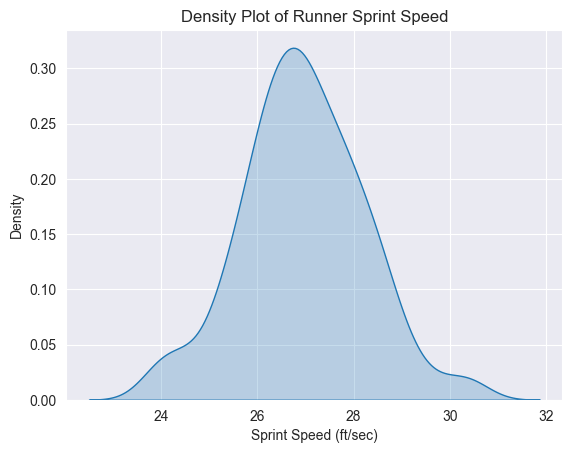

In [29]:
# Creating density plot of sprint speeds. Looks good so far.
sns.kdeplot(avg_speeds, fill=True)
plt.title("Density Plot of Runner Sprint Speed")
plt.xlabel("Sprint Speed (ft/sec)")
plt.ylabel("Density")
plt.savefig("ss_plot.png")
plt.show()

Already pretty close to normally distributed. CLT has my back otherwise.

Now, replace missing runners with mean, and runners outside of 3 std w mean (which isn't any of them)

In [30]:
mean_speed = np.mean(baserunners_df['speed'])
def assign_sprint_speed(row):
    '''
    Assigns sprint speed to rows where we have a batter, if not, assign the mean
    params:
    row: row of a df to be applied to (in my case, a pitch)
    returns:
    sprint speed for the runner on first base
    '''

    player_id = row['runner']

    if player_id == 'NA':
        return mean_speed
    else:
        if baserunners_df[baserunners_df['runner'] == player_id]['speed'].isna().any():
            return mean_speed
        else:
            return baserunners_df[baserunners_df['runner'] == player_id]['speed'].values[0]

pickoff_pitches['speed'] = pickoff_pitches.apply(assign_sprint_speed, axis=1)

In [304]:
# Saving df as a csv
# pickoff_pitches.to_csv("pickoff_pitches_refine.csv", index=False)

## Modeling

Building XGBoost Model

In [31]:
pickoff_pitches_df = pickoff_pitches

In [6]:
# Can also read in as csv
# pickoff_pitches_df = pd.read_csv("data_pickoffs.csv")

In [178]:
# from sklearn.model_selection import GridSearchCV
# features = ['pickoffs', 'inning', 'lead_adj', 'handedness', 'time_between', 'speed']
# target = 'steal'

# X = pickoff_pitches_df[features]
# y = pickoff_pitches_df[target]

# Train test split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.3, stratify=y, random_state=42
# )

# model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# params = {
#     'n_estimators': [100, 200, 300],
#    'learning_rate': [0.01, 0.02, 0.05],
#   'max_depth': [2, 3, 4],
#    'subsample': [0.6, 0.7, 0.8],
#   'min_child_weight': [1, 3, 5],
#    'max_delta_step': [1, 2, 3]
#}

# Grid Search
#grid = GridSearchCV(model, params, cv=5, scoring='roc_auc')
#grid.fit(X, y)

# print("Optimal parameters:", grid.best_params_)
# print("ROC-AUC score:", grid.best_score_)

Best parameters (according to ROC-AUC score): {'learning_rate': 0.02, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}. This is a good starting point, but I need to prioritize recall.

In [32]:
# Preparing the data

features = ['pickoffs', 'inning', 'lead_adj', 'handedness', 'time_between', 'speed']
target = 'steal'

X = pickoff_pitches_df[features]
y = pickoff_pitches_df[target]

# Train test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Fine tuning parameters
# Documentation: https://xgboost.readthedocs.io/en/stable/parameter.html

# Class imbalance -> steals happen infrequently

# ratio = steal (no) / steal (yes) https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets

ratio = len(pickoff_pitches_df[pickoff_pitches_df['steal'] == 0]) / len(pickoff_pitches_df[pickoff_pitches_df['steal'] == 1])

# Training the model

model = xgb.XGBClassifier(
    n_estimators=200, # Low learning rate, large number of boosting rounds since df is small
    learning_rate=0.02,
    objective='binary:logistic', # Output probability since we want steal % chances
    eval_metric='logloss', # Logloss as loss function
    scale_pos_weight=ratio, # Negative/positive ratio
    use_label_encoder=False,
    max_depth=2, # Shallow trees seem to work well here, as nothing *directly* pinpoints a sb attempt
    subsample=0.7, # Parameters that help with class imbalances
    min_child_weight=3,
    max_delta_step=2
)


In [33]:
# Fit the model
model.fit(X_train, y_train)

C:\Users\thesl\PycharmProjects\SMTDataChallenge\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:46:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [34]:
# Predictions
probabilities = model.predict_proba(X_test)[:, 1]
binary = model.predict(X_test)

In [35]:
# Create a testing results df for visualizations, csv
results_df = X_test.copy()
results_df['actual steal'] = y_test.values
results_df['predicted steal'] = binary
results_df['probability of steal'] = probabilities
results_df = results_df.reset_index(drop=True)

In [36]:
print(classification_report(y_test, binary))

              precision    recall  f1-score   support

           0       0.98      0.81      0.88       298
           1       0.16      0.65      0.26        17

    accuracy                           0.80       315
   macro avg       0.57      0.73      0.57       315
weighted avg       0.93      0.80      0.85       315



In [37]:
# AUC
print(f"AUC: {round(roc_auc_score(y_test, binary), 3)}") # 0.728

AUC: 0.728


Fine tuning some parameters bumped this up a bit

In [38]:
# Confusion Matrix https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

cm = confusion_matrix(y_test, binary)
tn, fp, fn, tp = cm.ravel()
print(f"True Positives (Steal attempt correctly predicted): {tp}")
print(f"True Negatives (A no steal attempt correctly predicted): {tn}")
print(f"False Positives (Incorrectly predicted steal attempt): {fp}")
print(f"False Negatives (Missed steal attempt): {fn}")

True Positives (Steal attempt correctly predicted): 11
True Negatives (A no steal attempt correctly predicted): 241
False Positives (Incorrectly predicted steal attempt): 57
False Negatives (Missed steal attempt): 6


In [39]:
cm.shape

(2, 2)

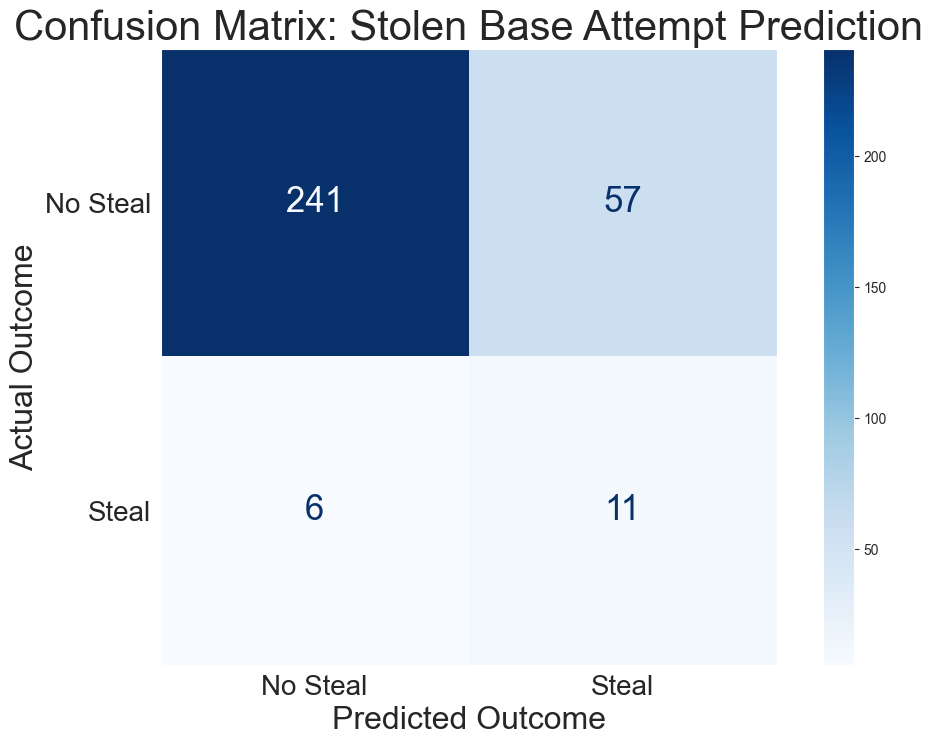

In [40]:
# Confusion Matrix Display visualization

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Steal', 'Steal'])
fig, ax = plt.subplots(figsize=(12, 8))
disp.plot(cmap="Blues", ax=ax, values_format='d')
for row in disp.text_:
    for text in row:
        text.set_fontsize(25)
disp.ax_.tick_params(axis='both', labelsize=20)
ax.set_title("Confusion Matrix: Stolen Base Attempt Prediction", fontsize=30)
ax.grid(False)
ax.set_xlabel("Predicted Outcome", fontsize=23)
ax.set_ylabel("Actual Outcome", fontsize=23)
plt.savefig("confusion_matrix.png")
plt.show()

In [41]:
# Making another visual representation of confusion matrix using great tables

cm_table = pd.DataFrame()
cm_table['Outcome'] = ['True Positives (Steal attempt correctly predicted)',
                       'True Negatives (A no steal attempt correctly predicted)',
                       'False Positives (Incorrectly predicted a steal attempt would occur)',
                       'False Negatives (Missed a steal attempt)']
cm_table['Count'] = [tp, tn, fp, fn]

gt.GT(cm_table).tab_style(
    style = gt.style.fill(color="#8FBCE6"),
    locations = gt.loc.body(columns = "Outcome",
                           rows = [0,2])
    ).tab_style(
    style = gt.style.fill(color="#F5D130"),
    locations = gt.loc.body(columns = "Outcome",
                           rows = [1,3])
    ).tab_style(
    style = gt.style.fill(color="white"),
    locations = gt.loc.body(columns = "Count",
                           rows = [0,1,2,3])
    ).save("Confusion.png")

Outcome,Count
True Positives (Steal attempt correctly predicted),11
True Negatives (A no steal attempt correctly predicted),241
False Positives (Incorrectly predicted a steal attempt would occur),57
False Negatives (Missed a steal attempt),6


When there is a steal, it correctly predicted it 67% of the time. It missed 33% of steals. It accurately predicted no steal 83% of the time.

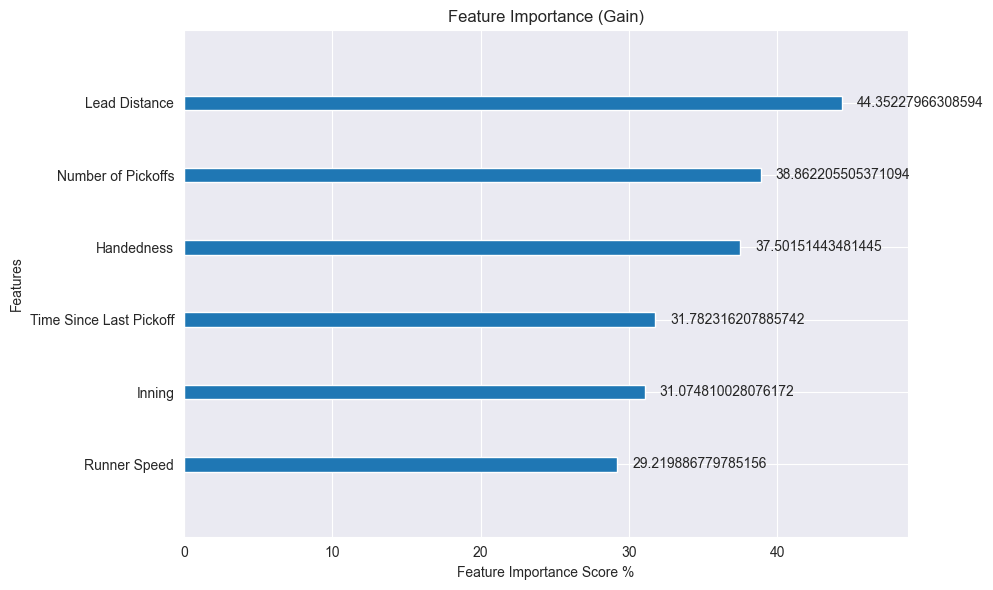

In [42]:
# Creating a feature importance chart using plot_importance

fig, ax = plt.subplots(figsize=(10, 6))
ax = xgb.plot_importance(model, ax=ax, importance_type='gain', title="Feature Importance (Gain)",
                         xlabel="Feature Importance Score %",)

# Rename features, manipulate img size for report purposes
feature_importances = {'pickoffs': 'Number of Pickoffs', 'inning' : 'Inning',
                        'lead_adj' : 'Lead Distance', 'handedness' : 'Handedness',
                        'time_between' : 'Time Since Last Pickoff', 'speed' : 'Runner Speed'}
xtick_labels = [feature_importances.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
ax.set_yticklabels(xtick_labels)
plt.tight_layout()
plt.savefig("importance_gain.png")
plt.show()

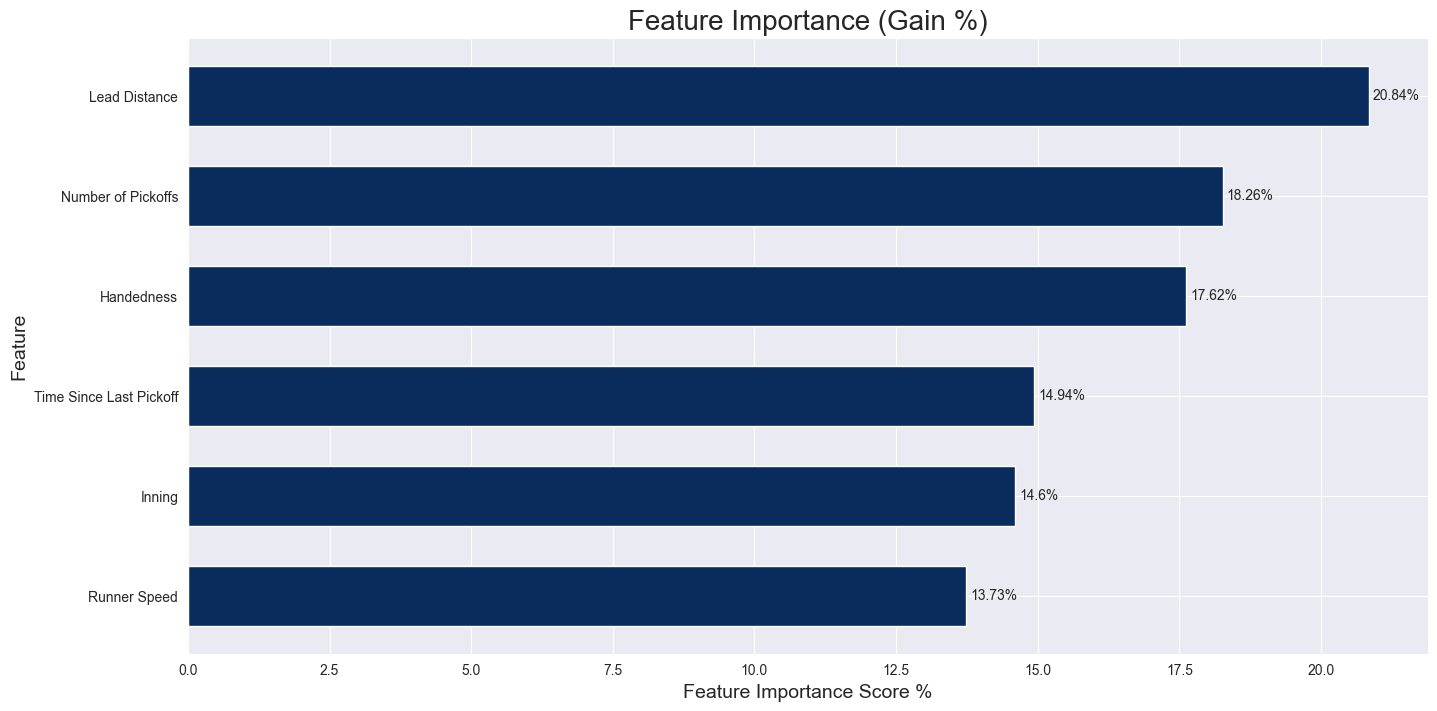

In [43]:
# Creating a custom feature importance plot but with % aggregate

gain_total = 44.35 + 38.86 + 37.50 + 31.78 + 31.07 + 29.22
feature_names = ['Lead Distance', 'Number of Pickoffs', 'Handedness',
                 'Time Since Last Pickoff', 'Inning', 'Runner Speed']
gain_values = [(44.35/gain_total) * 100, (38.86/gain_total) * 100, (37.50/gain_total) * 100,
               (31.78/gain_total) * 100, (31.07/gain_total) * 100, (29.22/gain_total) * 100]

gain_values_labels = list()
for i in gain_values:
    gain_values_labels.append(str(round(i, 2)) + '%')
fig, ax = plt.subplots(figsize=(16, 8))
plot = ax.barh(y=feature_names[::-1], width=gain_values[::-1], height=0.6,
               color='#092C5C')
ax.bar_label(plot, labels=gain_values_labels[::-1], padding=3)
plt.title("Feature Importance (Gain %)", fontsize=20)
plt.ylabel('Feature', fontsize=14)
plt.xlabel("Feature Importance Score %", fontsize=14)
plt.savefig("feature_importance_gain.png")
plt.show()

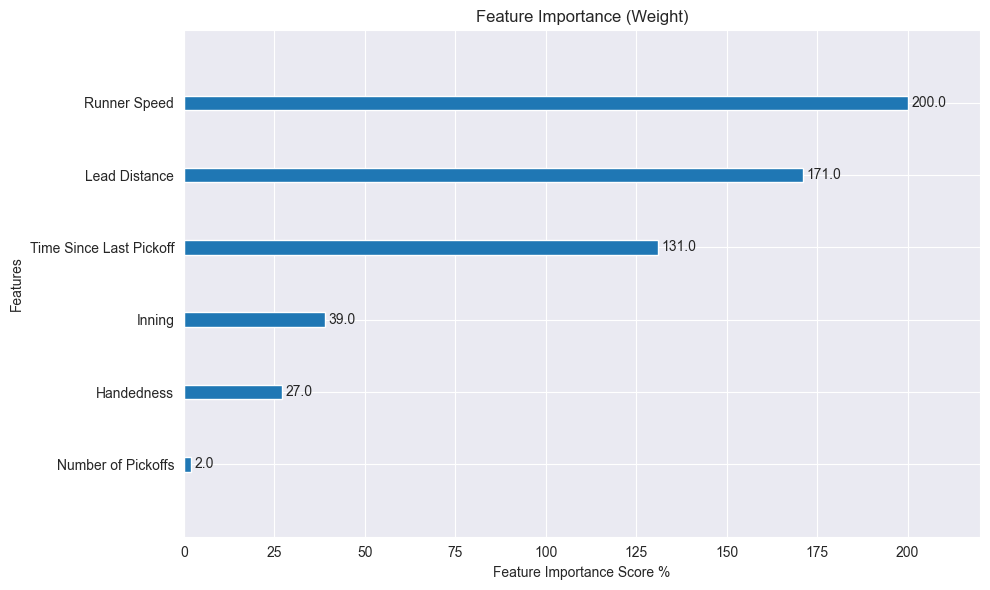

In [44]:
# Creating a feature importance chart using plot_importance (weight)

fig, ax = plt.subplots(figsize=(10, 6))
ax = xgb.plot_importance(model, ax=ax, importance_type='weight', title="Feature Importance (Weight)",
                         xlabel="Feature Importance Score %",)

# Rename features, manipulate img size for report purposes
feature_importances = {'pickoffs': 'Number of Pickoffs', 'inning' : 'Inning',
                        'lead_adj' : 'Lead Distance', 'handedness' : 'Handedness',
                        'time_between' : 'Time Since Last Pickoff', 'speed' : 'Runner Speed'}
xtick_labels = [feature_importances.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
ax.set_yticklabels(xtick_labels)
plt.tight_layout()
plt.savefig("importance_weight.png")
plt.show()

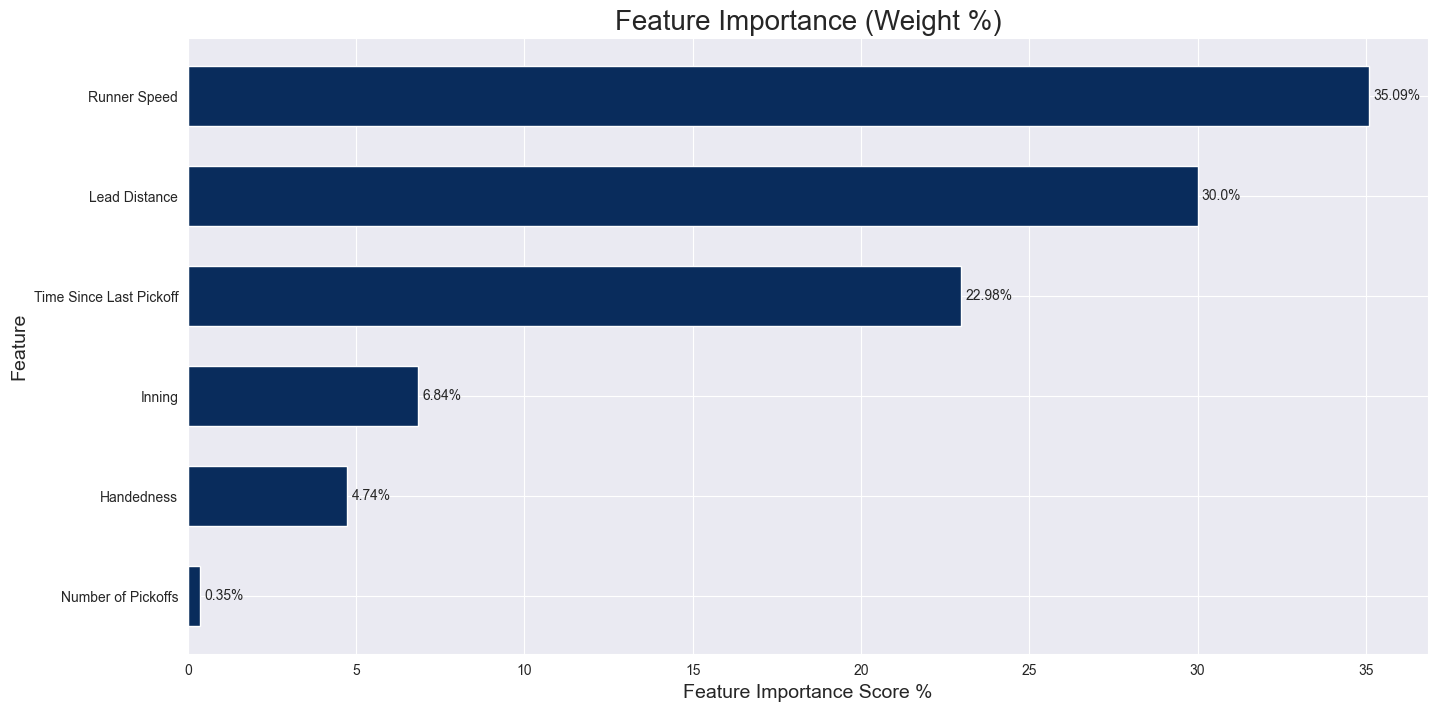

In [45]:
# Creating a custom feature importance plot but with % aggregate

weight_total = 2 + 27 + 39 + 131 + 171 + 200
feature_names_weight = ['Number of Pickoffs', 'Handedness', 'Inning',
                        'Time Since Last Pickoff', 'Lead Distance', 'Runner Speed']
weight_values = [(2/weight_total) * 100, (27/weight_total) * 100, (39/weight_total) * 100,
               (131/weight_total) * 100, (171/weight_total) * 100, (200/weight_total) * 100]

weight_values_labels = list()
for i in weight_values:
    weight_values_labels.append(str(round(i, 2)) + '%')
fig, ax = plt.subplots(figsize=(16, 8))
plot = ax.barh(y=feature_names_weight, width=weight_values, height=0.6,
               color='#092C5C')
ax.bar_label(plot, labels=weight_values_labels, padding=3)
plt.title("Feature Importance (Weight %)", fontsize=20)
plt.ylabel('Feature', fontsize=14)
plt.xlabel("Feature Importance Score %", fontsize=14)
plt.savefig("feature_importance_weight.png")
plt.show()

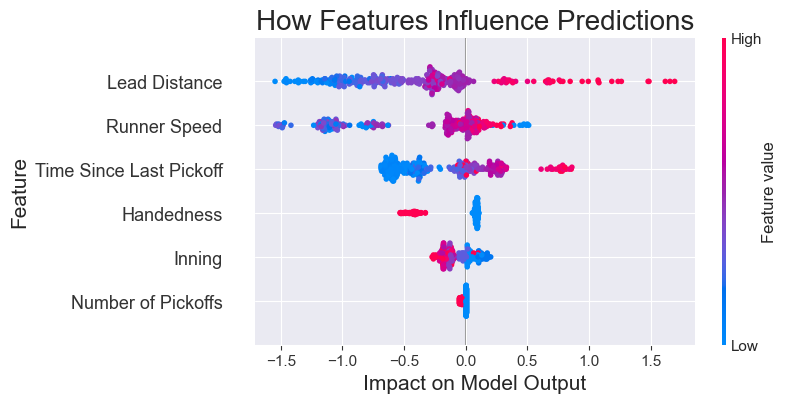

In [61]:
# Creating SHAP plot

# Following example from: https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html

X_test_renamed = X_test.copy().rename(columns={
    'pickoffs': 'Number of Pickoffs',
    'handedness': 'Handedness',
    'inning': 'Inning',
    'time_between': 'Time Since Last Pickoff',
    'lead_adj': 'Lead Distance',
    'speed': 'Runner Speed'
})
explainer = shap.Explainer(model)
explanation = explainer(X_test_renamed)
shap.summary_plot(explanation, X_test_renamed, show=False)
plt.title('How Features Influence Predictions', fontsize=20)
plt.xlabel('Impact on Model Output', fontsize=15)
plt.ylabel('Feature', fontsize=15)
plt.savefig('shap_summary.png', bbox_inches='tight')
plt.show()

In [48]:
# Great Table of 10 actual steals
gt.GT(results_df[results_df['actual steal'] == 1]).cols_label(
    pickoffs = "Number of Pickoffs",
    inning = "Inning",
    lead_adj = "Lead Distance from 1b(feet)",
    handedness = "Handedness (0 for right, 1 for left)",
    time_between = "Time Between Pitch and Last Pickoff",
    speed = "Runner Speed"
).tab_header(title = "Stolen Base Attempts Detected in Test Data").save("Stolen-Base-Attempts-Detected-in-Test-Data.png")

GT(_tbl_data=     pickoffs  inning   lead_adj  handedness  time_between      speed  \
2           2       3  11.475585         0.0        96.050  26.952168   
3           1       7  14.131794         0.0        42.600  26.952168   
5           1       7  15.751040         0.0        22.100  26.925229   
10          1       4  15.181248         0.0        21.879  27.639233   
25          1       3  16.855956         0.0        23.650  26.966952   
38          2       5  10.431143         0.0        96.724  28.015318   
53          1       1  18.299097         0.0        21.100  26.952168   
68          2       3  10.329982         1.0        15.200  27.119660   
88          1       6  17.103749         0.0        53.700  27.062664   
150         2       9  12.809548         0.0        22.374  27.119018   
152         1       1  11.492841         0.0        53.450  27.119018   
166         2       3  10.952704         0.0        49.050  25.403284   
181         1       1  15.138209         0.0        18.900  26.952168   
223         2       3  10.599996         0.0        16.400  26.952168   
231         1       7  11.763154         0.0       160.000  26.610207   
240         1       2  13.059154         0.0        80.550  26.952168   
310         1       6  11.316520         0.0        14.200  28.119994   

     actual steal  predicted steal  probability of steal  
2               1                1              0.605005  
3               1                1              0.723372  
5               1                1              0.655532  
10              1                1              0.660043  
25              1                1              0.794297  
38              1                1              0.551529  
53              1                1              0.830174  
68              1                0              0.167448  
88              1                1              0.870090  
150             1                0              0.320720  
152             1                1              0.560702  
166             1                0              0.334114  
181             1                1              0.653173  
223             1                0              0.324997  
231             1                0              0.300229  
240             1                1              0.623947  
310             1                0              0.429665  , _body=<great_tables._gt_data.Body object at 0x000001E90ECE2CC0>, _boxhead=Boxhead([ColInfo(var='pickoffs', type=<ColInfoTypeEnum.default: 1>, column_label='Number of Pickoffs', column_align='right', column_width=None), ColInfo(var='inning', type=<ColInfoTypeEnum.default: 1>, column_label='Inning', column_align='right', column_width=None), ColInfo(var='lead_adj', type=<ColInfoTypeEnum.default: 1>, column_label='Lead Distance from 1b(feet)', column_align='right', column_width=None), ColInfo(var='handedness', type=<ColInfoTypeEnum.default: 1>, column_label='Handedness (0 for right, 1 for left)', column_align='right', column_width=None), ColInfo(var='time_between', type=<ColInfoTypeEnum.default: 1>, column_label='Time Between Pitch and Last Pickoff', column_align='right', column_width=None), ColInfo(var='speed', type=<ColInfoTypeEnum.default: 1>, column_label='Runner Speed', column_align='right', column_width=None), ColInfo(var='actual steal', type=<ColInfoTypeEnum.default: 1>, column_label='actual steal', column_align='right', column_width=None), ColInfo(var='predicted steal', type=<ColInfoTypeEnum.default: 1>, column_label='predicted steal', column_align='right', column_width=None), ColInfo(var='probability of steal', type=<ColInfoTypeEnum.default: 1>, column_label='probability of steal', column_align='right', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x000001E90EC6F230>, _spanners=Spanners([]), _heading=Heading(title='Stolen Base Attempts Detected in Test Data', subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[], _local

## Other Statistical Analysis And Visualizations

Looking at leads in different conditions: hypothesis testing

In [49]:
mean_lead_sb = np.mean(pickoff_pitches_df[(pickoff_pitches_df['steal'] == 1)]['lead_adj'])
mean_lead_no_sb = np.mean(pickoff_pitches_df[(pickoff_pitches_df['steal'] == 0)]['lead_adj'])
print(f"Lead distance when steal: {round(mean_lead_sb, 2)}, lead distance when no steal: {round(mean_lead_no_sb, 2)}")

Lead distance when steal: 13.4, lead distance when no steal: 11.04


In [50]:
t_stat, p_val = ttest_ind(pickoff_pitches_df[(pickoff_pitches_df['steal'] == 1)]['lead_adj'], pickoff_pitches_df[(pickoff_pitches_df['steal'] == 0)]['lead_adj'], equal_var=False)  # Welch's t-test

print(f"T-statistic: {round(t_stat, 3)}, P-value: {round(p_val, 4)}")

T-statistic: 5.933, P-value: 0.0


Since the p-value is less than 0.01, we have strong evidence to reject the null hypothesis and conclude that the means of the two groups are significantly different.

Furthermore, the t-statistic of 5.297 indicates that the group means are approximately 5.3 standard errors apart, which reflects a substantial difference relative to the variability in the data.

In [51]:
len(pickoff_pitches_df[(pickoff_pitches_df['steal'] == 1) &
                       (pickoff_pitches_df['handedness'] == 1)])
# 6 steal attempts v lefties in MY entire dataset (wow)

6

Only 6 sb attempts against lefties - might mess up this feature during modeling

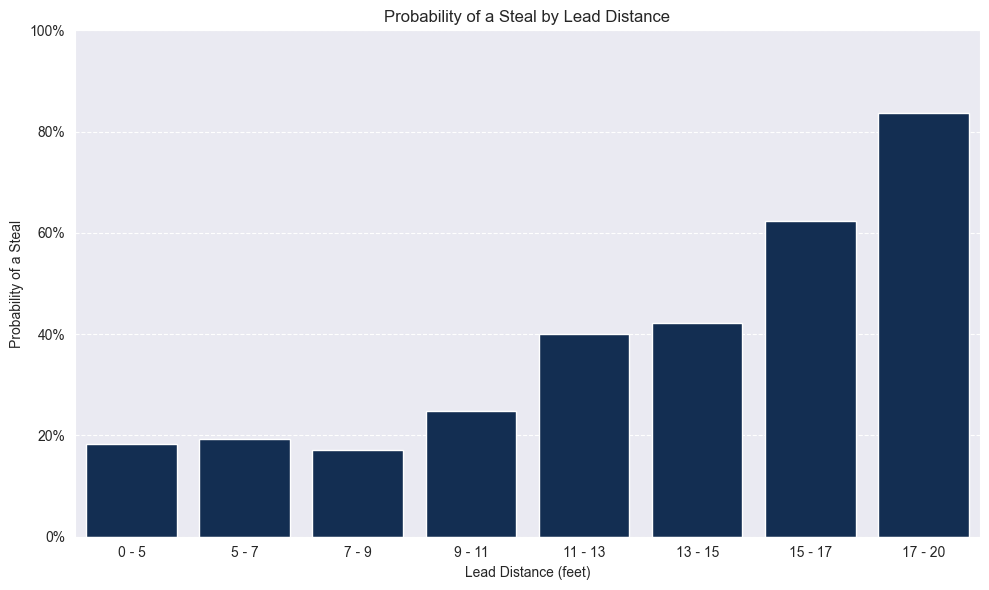

In [52]:
# Bar Graph of leads and probabilities of stealing
lead_probs = pd.DataFrame()
bins = ['0 - 5', '5 - 7', '7 - 9', '9 - 11',
        '11 - 13', '13 - 15','15 - 17', '17 - 20']
bins_int = [[0, 5], [5, 7], [7, 9], [9, 11],
            [11, 13], [13, 15], [15, 17], [17, 20]]
avg_probs = list()
for bin in bins_int:
    probs = results_df[(results_df['lead_adj'] >= bin[0]) &
                       (results_df['lead_adj'] < bin[1])
    ]['probability of steal']
    avg_prob = np.mean(probs)
    avg_probs.append(avg_prob)

lead_probs['Lead Distance (ft)'] = bins
lead_probs['Chance of a Steal'] = avg_probs

plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(data=lead_probs, x='Lead Distance (ft)',
            y='Chance of a Steal', color='#092C5C')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Probability of a Steal by Lead Distance')
plt.xlabel('Lead Distance (feet)')
plt.ylabel('Probability of a Steal')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('StealRate.png')
plt.show()

In [53]:
print(np.percentile(results_df['time_between'], 20)) # 19.2
print(np.percentile(results_df['time_between'], 40)) # 23.68
print(np.percentile(results_df['time_between'], 60)) # 43.99
print(np.percentile(results_df['time_between'], 80)) # 69.05
print(np.percentile(results_df['time_between'], 90)) # 95.37

19.2
23.68
43.99
69.05
95.37000000000003


In [54]:
min(results_df['time_between'])

13.3

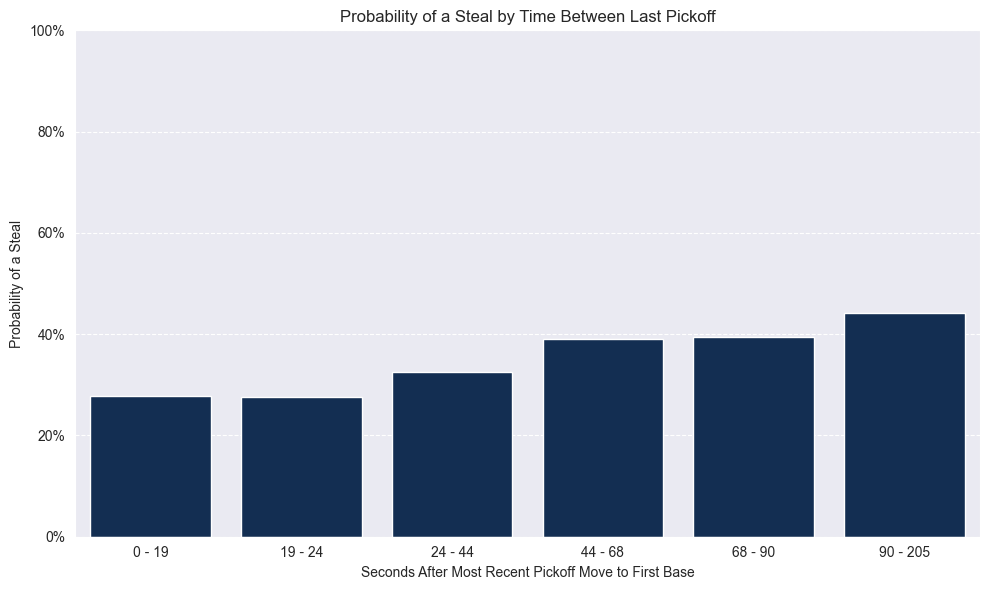

In [55]:
# Bar Graph of time between pitches and probabilities of stealing
lead_probs_seconds = pd.DataFrame()
bins = ['0 - 19', '19 - 24', '24 - 44',
        '44 - 68', '68 - 90', '90 - 205']
bins_int = [[0, 19], [19, 24], [24, 44], [44, 68],
            [68, 90], [90, 205]]
avg_probs = list()
for bin in bins_int:
    probs = results_df[(results_df['time_between'] >= bin[0]) &
                       (results_df['time_between'] < bin[1])
    ]['probability of steal']
    avg_prob = np.mean(probs)
    avg_probs.append(avg_prob)

lead_probs_seconds['Seconds'] = bins
lead_probs_seconds['Chance of a Steal'] = avg_probs

plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(data=lead_probs_seconds, x='Seconds',
            y='Chance of a Steal', color='#092C5C')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Probability of a Steal by Time Between Last Pickoff')
plt.xlabel('Seconds After Most Recent Pickoff Move to First Base')
plt.ylabel('Probability of a Steal')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('StealRate_TimeBetween.png')
plt.show()

In [56]:
# Figuring out how to spread apart speeds in test data for visualization
print(f"First quartile sprint speed: {np.percentile(results_df['speed'], 25)}")
print(f"Second quartile sprint speed: {np.percentile(results_df['speed'], 50)}")
print(f"Third quartile sprint speed: {np.percentile(results_df['speed'], 75)}")
print(f"Forth quartile sprint speed: {np.percentile(results_df['speed'], 100)}")

First quartile sprint speed: 26.415463362884587
Second quartile sprint speed: 26.966952270895444
Third quartile sprint speed: 27.494357492330114
Forth quartile sprint speed: 29.94177079005908


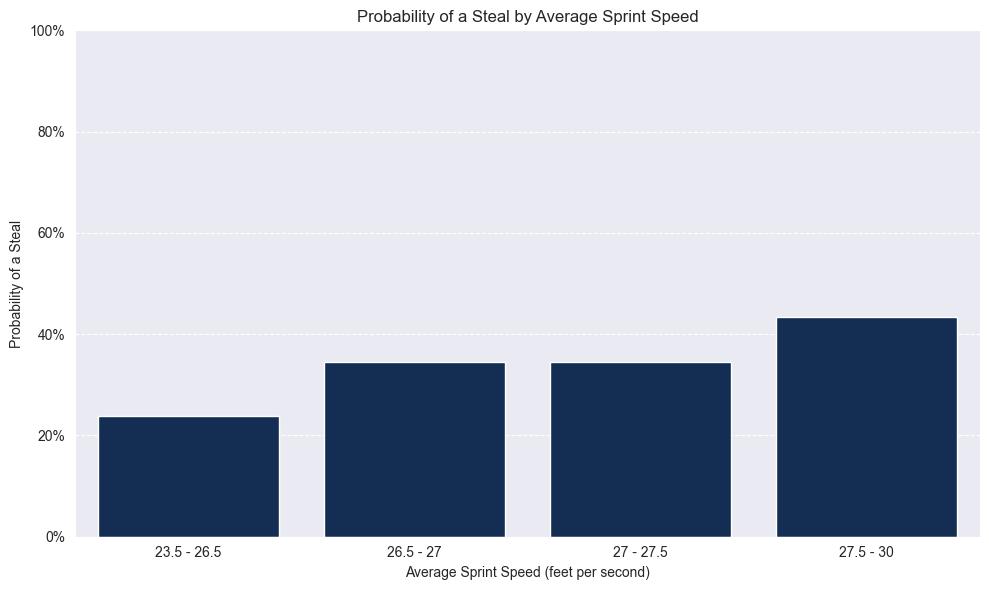

In [57]:
# Bar Graph of speed and probabilities of stealing
lead_probs_speed = pd.DataFrame()
bins = ['23.5 - 26.5', '26.5 - 27',
        '27 - 27.5', '27.5 - 30']
bins_int = [[23.5, 26.5], [26.5, 27], [27, 27.5], [27.5, 30]]
avg_probs = list()
for bin in bins_int:
    probs = results_df[(results_df['speed'] >= bin[0]) &
                       (results_df['speed'] < bin[1])
    ]['probability of steal']
    avg_prob = np.mean(probs)
    avg_probs.append(avg_prob)

lead_probs_speed['Speed'] = bins
lead_probs_speed['Chance of a Steal'] = avg_probs

plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(data=lead_probs_speed, x='Speed',
            y='Chance of a Steal', color='#092C5C')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Probability of a Steal by Average Sprint Speed')
plt.xlabel('Average Sprint Speed (feet per second)')
plt.ylabel('Probability of a Steal')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('StealRate_Speed.png')
plt.show()

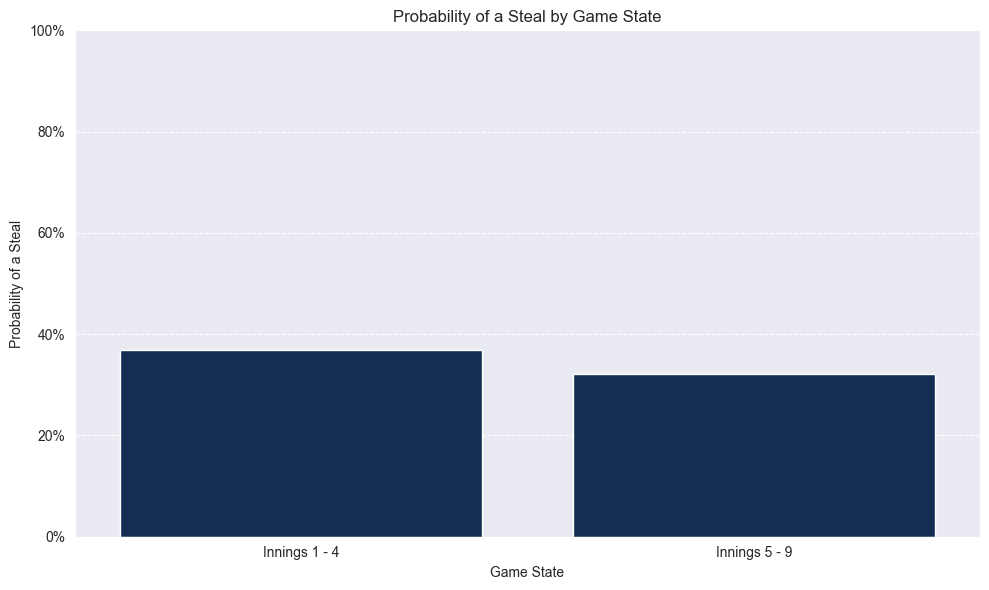

In [58]:
# Bar Graph of inning and probabilities of stealing
lead_probs_inning = pd.DataFrame()
bins = ['Innings 1 - 4', 'Innings 5 - 9']
bins_int = [[1, 4], [5, 13]]
avg_probs = []
for bin in bins_int:
    probs = results_df[(results_df['inning'] >= bin[0]) &
                       (results_df['inning'] < bin[1])
    ]['probability of steal']
    avg_prob = np.mean(probs)
    avg_probs.append(avg_prob)

lead_probs_inning['Inning'] = bins
lead_probs_inning['Chance of a Steal'] = avg_probs

plt.figure(figsize=(10, 6), facecolor='white')
sns.barplot(data=lead_probs_inning , x='Inning',
            y='Chance of a Steal', color='#092C5C')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.title('Probability of a Steal by Game State')
plt.xlabel('Game State')
plt.ylabel('Probability of a Steal')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.savefig('StealRate_Inning.png')
plt.show()

It does not seem to matter

Exporting test predictions to .csv

In [857]:
# results_df.to_csv("test_results2.csv", index=False)
# pickoff_pitches_df.to_csv("data_pickoffs.csv", index=False)

In [858]:
# Exporting model as .json for shinyapp in R (shinyapp file in RStudio is just easy)
# model.save_model("pickoff_takeoff_model.json")

MovieWriter imagemagick unavailable; using Pillow instead.


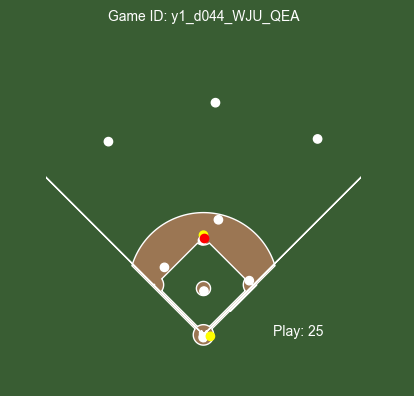

In [59]:
# For GIF visualizations
## Filter player position data to the specific game that we want to focus on
player_position_df = player_position_subset.to_table(filter = (pads.field('game_str') == 'y1_d044_WJU_QEA')).to_pandas()

# Read in ball position data and filter to same game as player_position
ball_position_df = ball_position_subset.to_table(filter = (pads.field('game_str') == 'y1_d044_WJU_QEA')).to_pandas()

# Animate play
# Arguments are player_pos, ball_pos, play_id, and whether we want to save the animation afterwards
plot_animation(player_position_df, ball_position_df, 25, True)